# Computing communities in large networks using random walks

## Generate random graph with two communities

In [94]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import copy
%matplotlib inline

In [101]:
# Setup the graph, with n vertices
N = 40
num_clusters = 4
A = np.eye(N, dtype=int)
p_edge = 0.98

In [102]:
#assign clusters to edges
# # random assignement
# cluster_assignements = np.random.randint(num_clusters, size=N)
# same number for each cluster
cluster_assignements = np.repeat(np.arange(num_clusters), int(N/num_clusters))
print(cluster_assignements)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


In [103]:
# create random edges
for i in range(N):
    for j in range(i, N):
        p = p_edge if cluster_assignements[i] == cluster_assignements[j] else (1 - p_edge)
        A[i,j] = max(A[i,j], p > np.random.rand())
        A[j,i] = A[i,j]

In [90]:
# Use example from the paper instead
N = 16
num_clusters = 2
A = np.eye(N, dtype=int)
cluster_assignements = np.array([1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0])
edges = [
    (0,4),
    (0,6),
    (1,2),
    (1,3),
    (1,4),
    (1,8),
    (2,3),
    (2,4),
    (2,5),
    (2,7),
    (3,6),
    (4,5),
    (5,6),
    (5,9),
    (6,7),
    (7,9),
    (8,9),
    (8,10),
    (8,11),
    (8,12),
    (8,14),
    (9,10),
    (9,14),
    (11,13),
    (12,13),
    (12,14),
    (13,14),
    (14,15)
]
for (i,j) in edges:
    A[i,j] = 1
    A[j,i] = 1

In [104]:
#compute the number of edges
M = (np.sum(A) + N) / 2
print("Num edges: {}".format(M))

Num edges: 229.0


In [105]:
cluster_nodes = [list(np.where(cluster_assignements == i)[0]) for i in range(num_clusters)]
print(cluster_nodes)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]]


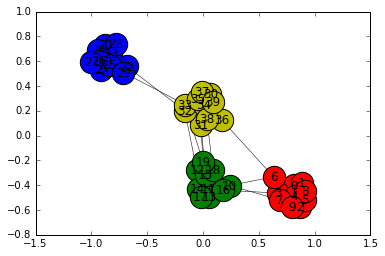

In [106]:
#draw the graph
def draw_graph(clusters, num_clusters):
    colors = ['r', 'g', 'b', 'y', 'b']
    G = nx.from_numpy_matrix(A)
    pos = nx.spring_layout(G)
    for i in range(num_clusters):
        nx.draw_networkx_nodes(G, pos, nodelist=clusters[i], node_color=colors[i % len(colors)], node_size=500, alpha=1)
    # nx.draw_networkx_nodes(G, pos, nodelist=cluster2_nodes, node_color='g', node_size=500, alpha=1)
    nx.draw_networkx_edges(G, pos, width=0.5)
    nx.draw_networkx_labels(G, pos, {i:i for i in range(N)})
draw_graph(cluster_nodes, num_clusters)

## Computing distances

### Helper functions

In [107]:
degrees = np.sum(A, axis=1)
D_inv = np.diag(1/degrees)
def distance(P_i, P_j):
    return np.sqrt(np.sum(((P_i - P_j) ** 2) / degrees))

def distance2(P_i, P_j):
    return np.sqrt(np.sum((np.dot(D_inv/2, P_i) - np.dot(D_inv/2, P_j)) ** 2))

def Δσ(l1, P_1, l2, P_2):
    return 1 / N * l1 * l2 / (l1 + l2) * (distance(P_1,P_2) ** 2)

In [108]:
#find the two clusters C1 and C2 with the smallest Δσ(C1, C2)
def find_to_merge(clusters):
    # find minimum Δσ for two clusters
    min_Δσ = None
    to_merge = []
    for i, cluster in clusters.items():
        for j, dist in cluster['neighbours'].items():
            if min_Δσ == None or dist < min_Δσ:
                min_Δσ = dist
                to_merge = [(i, j)]
            elif (dist == min_Δσ):
                to_merge.append((i,j))
    return (to_merge[0][0], to_merge[0][1], min_Δσ)

In [109]:
# Given clusters, merge C1 and C2 into a new cluster with id new_id
def merge_clusters(C1, C2, clusters, new_id):
    l1 = len(C1['nodes'])
    l2 = len(C2['nodes'])
    # Create new Cluster, merging C1 and C2
    new_nodes = C1['nodes'].union(C2['nodes'])
    new_neighbours = set(C1['neighbours'].keys()).union(set(C2['neighbours'].keys()))
    new_neighbours.remove(i)
    new_neighbours.remove(j)
    
    #compute the P_t for the new cluster
    new_P_t = (l1 * C1['P_t'] + l2 * C2['P_t']) / (l1 + l2)
    
    #compute new_P_t manually, sanity check
    new_P_t2 = np.zeros(N)
    for node in new_nodes:
        new_P_t2 += P_t[node]
    new_P_t2 /= len(new_nodes)

    assert(np.allclose(new_P_t, new_P_t2))
    
    # Compute Δσ's for the new cluster
    neighbours = {}
    for n in new_neighbours:
        C = clusters[n]
        l3 = len(C['nodes'])
        if n in C1['neighbours'].keys() and n in C2['neighbours'].keys():
            #apply Theorem 4
            x_A = (l1 + l3) * C1['neighbours'][n]
            x_B = (l2 + l3) * C2['neighbours'][n]
            x_C = (l3) * C1['neighbours'][j]
            new_Δσ = (x_A + x_B - x_C) / (l1 + l2 + l3)
            new_Δσ2 = Δσ(l1+l2, new_P_t, l3, C['P_t'])
            assert(np.isclose(new_Δσ, new_Δσ2))
        else:
            #apply Theorem 3
            new_Δσ = Δσ(l1+l2, new_P_t, l3, C['P_t'])
    #       new_Δσ2 = (l1 + l2) * l3  * (distance(new_P_t, C['P_t']) ** 2) / N / (l1 + l2 + l3)
    #       assert(np.isclose(new_Δσ, new_Δσ2))
        
        neighbours[n] = new_Δσ
        C['neighbours'].pop(i, None)
        C['neighbours'].pop(j, None)
        C['neighbours'][new_id] = new_Δσ
    
    new_cluster = {
        'nodes': new_nodes,
        'neighbours': neighbours,
        'P_t': new_P_t
    }
    
    return new_cluster

In [110]:
def create_partition(clusters):
    return [C['nodes'] for C in clusters.values()]

In [111]:
# Compute the modularity of a given partition
def modularity2(partition):
    def edge_fraction(C1, C2):
        sum = 0
        # need to check if C1==C2, as we would be counting edges multiple times
        if (C1 == C2):
            nodes1 = list(C1)
            nodes2 = list(C2)
            for i in range(len(C1)):
                for j in range(i, len(C2)):
                    if (A[nodes1[i],nodes2[j]] == 1):
                        sum += 1
        else:
            for i in C1:
                for j in C2:
                    if (A[i,j] == 1):
                        sum += 1
        return sum/ (M)
    
    def edges_bound(C1):
        sum = 0
        for C in partition:
            e = edge_fraction(C1, C)
            sum += e
        return sum
    
#     for C in partition:
#         for C2 in partition:
#             print("{},{}: {}".format(C, C2, edge_fraction(C, C2) * M))

    modularity = 0.0
    for C in partition:
#         print(C)
        e_C = edge_fraction(C,C)
#         print("e_C: {}".format(e_C * M))
        a_C = edges_bound(C)
#         print("a_C: {}".format(a_C * M))
        modularity += e_C - (a_C**2)
    return modularity

### Create partitions

In [112]:
# Create transition matrix
np.set_printoptions(precision=4)
P = np.dot(D_inv, A)

In [113]:
#Compute probability vectors
t = 3
P_t = np.eye(N)
for i in range(t):
    P_t = np.dot(P, P_t)

In [114]:
#create initial clusters
A2 = A - np.eye(N)
clusters = {}
for i in range(N):
    nodes = {i}
    neighbours = {}
    for j in range(N):
        if A[i,j] and i != j:
            neighbours[j] = Δσ(1, P_t[i], 1, P_t[j])
    clusters[i] = {
        'nodes': nodes,
        'P_t': P_t[i],
        'neighbours': neighbours
    }
# merge clusters repeatedly
new_id = N
build_tree = []
Δσs = []
partitions = [create_partition(clusters)]
while(len(clusters) > 1):    
    # find clusters to merge
    (i,j, min_Δσ) = find_to_merge(clusters)
    # Compute new partion
    clusters[new_id] = merge_clusters(clusters[i],clusters[j], clusters, new_id)
    clusters.pop(i)
    clusters.pop(j)
    
    # For dendogram
    build_tree.append((new_id, i, j))
    # Keep track of partitions
    partitions.append(create_partition(clusters))
    # For evaluation of partitions
    Δσs.append(min_Δσ)
    
    new_id += 1

### Evaluate partitions and choose optimal

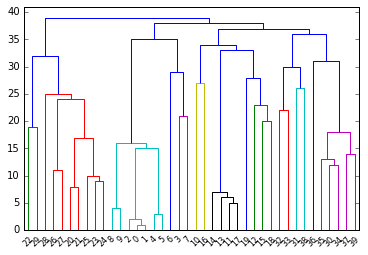

In [115]:
#create linkage matrix
Z = np.array([[id1, id2, j+1, 0] for (j, (new_id, id1, id2)) in enumerate(build_tree)], dtype=np.double)
dendrogram(Z);

In [123]:
# Compute modularities
Ps = partitions
Qs = [modularity2(Ps[N-i]) for i in range(1, N)]

In [124]:
#compute η's
η = []
for i in range(0, len(Δσs) - 1):
    if Δσs[i] == 0:
        η.append(0)
    else: 
        η.append(Δσs[i+1]/Δσs[i])
η = np.flip(η, axis=0)

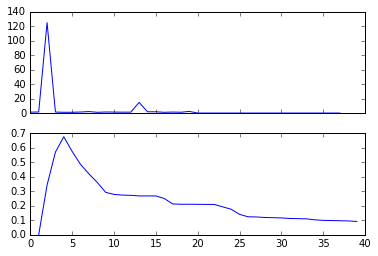

In [125]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(range(len(η)),η)
axarr[1].plot(range(1,N), Qs)

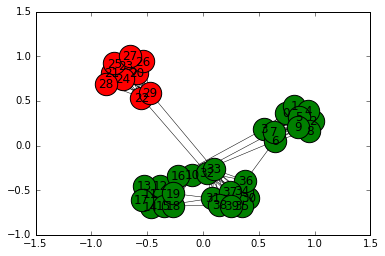

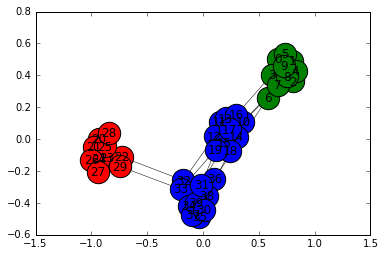

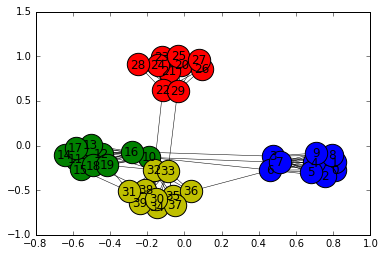

In [126]:
draw_graph(Ps[N-2], 2)
plt.figure()
draw_graph(Ps[N-3], 3)
plt.figure()
draw_graph(Ps[N-4], 4)

2
4


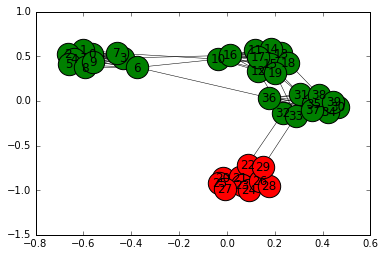

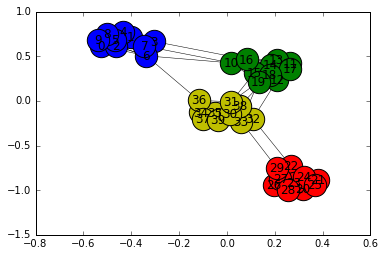

In [128]:
best_num_clusters = np.argmax(η)
print(best_num_clusters)
draw_graph(Ps[N-best_num_clusters], best_num_clusters)
plt.figure()
best_num_clusters_Qs = np.argmax(Qs) + 1
print(best_num_clusters_Qs)
draw_graph(Ps[N-best_num_clusters_Qs], best_num_clusters_Qs)